In [1]:
# Import necessary libraries and the custom optimizer

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 

import jax.numpy as jnp
from jax import config
import dynamiqs as dq
import qutip as qt
import tensorflow as tf

import utilities as utl
from load_and_plot import plot_evolution
from optimizers import HardwareAwareOptimizer

%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", False)
tf.keras.backend.set_floatx('float32')
dq.set_progress_meter(False)

%matplotlib qt

# Set a global seed for reproducible results
seed_value = 44
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
mpl.rcParams['figure.raise_window'] = False

# Cat State:

## Pre-training:

In [2]:
# Load a pulse obtained from gradient descent
# It should be a numpy array of shape (4, n_pulse_points)
print("Loading a sample pulse for pre-training...")

directory = '/Users/saswataroy/OptimalControl/pulses/'
data = np.load(directory + 'fock_2_prep.npz')
amps = data["arr_0"]

ideal_pulse = amps

print("Sample pulse loaded.")

Loading a sample pulse for pre-training...
Sample pulse loaded.


In [2]:
# DEFINE SIMULATION AND PHYSICS PARAMETERS
fourier_scale = 15
# Instantiate the main optimizer class
# Define the scaling factors for the output layer.
# These values multiply the standard Glorot-initialized weights.
# Format: (I_cavity, Q_cavity, I_qubit, Q_qubit)
init_scales = (8.0, 8.0, 18.0, 18.0)

# Simulation parameters
osc_drive_type = 'linear'
ncav = 20  # Hilbert space dimension for the oscillator
ntr = 2    # Hilbert space dimension for the transmon

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = -0.0242 * (2 * np.pi)
chi = -3.649 * (2 * np.pi)
chi_prime = +0.039 * (2 * np.pi)

# Pulse parameters
T = 1 # Total pulse time in microseconds
ntsave = 1001
ntpulse = 1001
max_amp = 5 * np.pi * 2 # Max amplitude for the drives
max_freq = 25 # Max frequency component in MHz (+- max_freq is allowed)

# SETUP HAMILTONIAN, STATES, AND OPERATORS ---
# Operators
a, adag = dq.destroy(ncav), dq.create(ncav)
t, tdag = dq.destroy(ntr), dq.create(ntr)
idcav, idtr = dq.eye(ncav), dq.eye(ntr)

# Define Binomial codewords and errorwords
L0 = (dq.basis(ncav, 0) + dq.basis(ncav, 4)) / jnp.sqrt(2)
L1 = dq.basis(ncav, 2)

plus_X = dq.unit((L0 + L1) / jnp.sqrt(2)) 
minus_X = dq.unit((L0 - L1) / jnp.sqrt(2))
plus_Y = dq.unit((L0 + 1j*L1) / jnp.sqrt(2)) 
minus_Y = dq.unit((L0 - 1j*L1) / jnp.sqrt(2))

# Error words:
E0 = dq.basis(ncav, 3)
E1 = dq.basis(ncav, 1)
E_plus_X = dq.unit((E0 + E1) / jnp.sqrt(2))
E_minus_X = dq.unit((E0 - E1) / jnp.sqrt(2))
E_plus_Y = dq.unit((E0 + 1j*E1) / jnp.sqrt(2))
E_minus_Y = dq.unit((E0 - 1j*E1) / jnp.sqrt(2))

targ_state = dq.unit(dq.coherent(ncav,2.2) + dq.coherent(ncav, -2.2))

psi0 = [dq.tensor(dq.basis(ncav,0), dq.basis(ntr,0))]

exp_ops = [dq.tensor(dq.proj(targ_state), dq.proj(dq.basis(ntr,0)))]

# Time arrays
tsave = jnp.linspace(0.0, T, ntsave, dtype = jnp.float32)
tpulse = jnp.linspace(0.0, T, ntpulse, dtype = jnp.float32)

# Static Hamiltonian
H0 = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
     (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t)

# Create the master parameter dictionary
my_params = {'H0': H0, 
             'ncav': ncav, 
             'ntr': ntr, 
             'alpha': alpha, 
             'K': K, 
             'chi': chi,
             'chi_prime': chi_prime, 
             'T': T, 
             'ntsave': ntsave, 
             'ntpulse': ntpulse,
             'max_amp': max_amp, 
             'max_freq': max_freq, 
             'psi0': psi0, 
             'exp_ops': exp_ops, 
             'tsave': tsave, 
             'tpulse': tpulse, 
             'osc_drive': osc_drive_type,
             'fourier_scale':fourier_scale,
             'init_scales':init_scales}

In [3]:
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

Initializing Optimizer...
Neural network model created.


In [4]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,  # How often to decay
    decay_rate=0.95)   # How much to decay by

# Pre-train the network on the GRADIENT descent generated pulse
optimizer.pre_train(
    ideal_pulse_arrays=ideal_pulse,
    time_array=my_params['tpulse'][:-1],
    epochs= 75000,
    learning_rate=1e-3
)

NameError: name 'ideal_pulse' is not defined

Verifying the pre-trained pulse...
Generating pulse from the trained model...
Mean Squared Error (NN vs Ideal): 152.735471


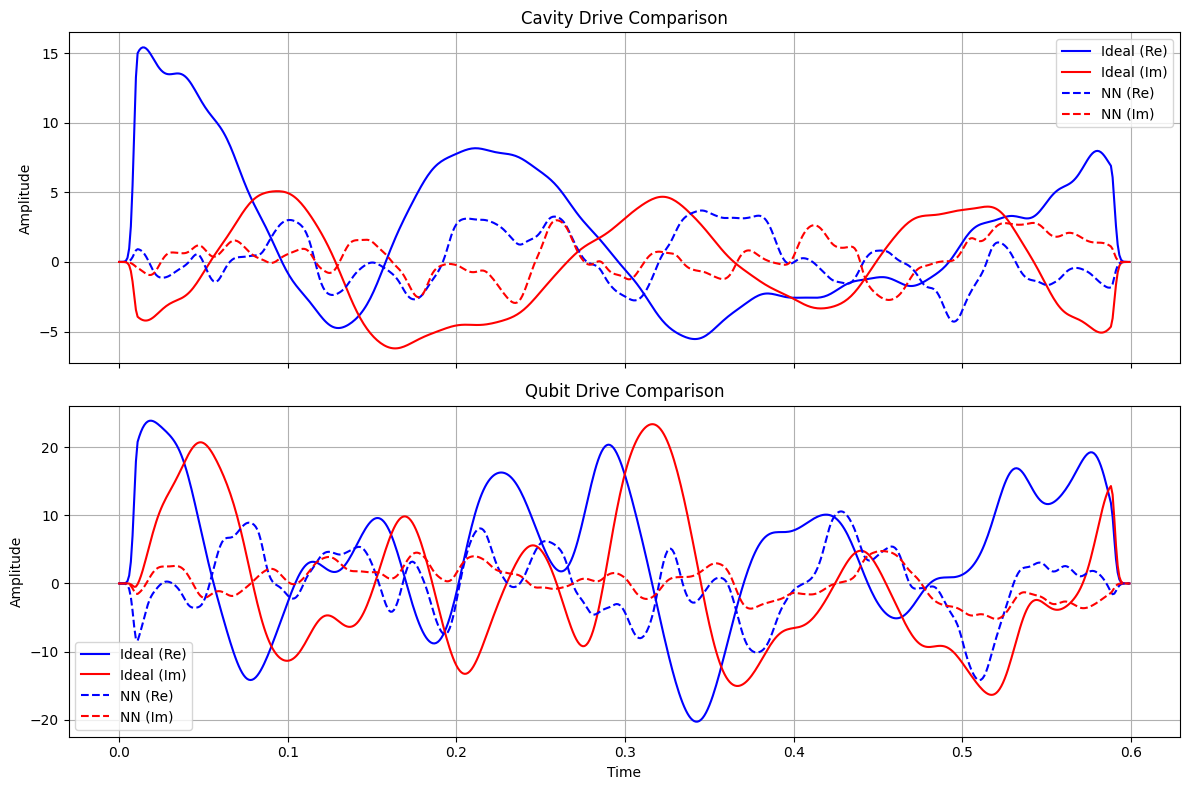

In [6]:
%matplotlib inline
print("Verifying the pre-trained pulse...")

# Prepare the time vector input for the model
time_array = my_params['tpulse'][:-1]
time_input = tf.constant(time_array, dtype=tf.float64)
time_input = tf.reshape(time_input, (1, len(time_array), 1))

# Generate a pulse from the trained network
generated_pulse_np = optimizer.generate_pulse()

ideal_pulse_complex = amps

# Numerically compare by calculating the Mean Squared Error
mse = np.mean(np.abs(np.square(generated_pulse_np - ideal_pulse_complex)))
print(f"Mean Squared Error (NN vs Ideal): {mse:.6f}")

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(ideal_pulse_complex[0, :]), 'b-', label='Ideal (Re)')
axs[0].plot(time_array, np.imag(ideal_pulse_complex[0, :]), 'r-', label='Ideal (Im)')
axs[0].plot(time_array, np.real(generated_pulse_np[0, :]), 'b--', label='NN (Re)')
axs[0].plot(time_array, np.imag(generated_pulse_np[0, :]), 'r--', label='NN (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(ideal_pulse_complex[1, :]), 'b-', label='Ideal (Re)')
axs[1].plot(time_array, np.imag(ideal_pulse_complex[1, :]), 'r-', label='Ideal (Im)')
axs[1].plot(time_array, np.real(generated_pulse_np[1, :]), 'b--', label='NN (Re)')
axs[1].plot(time_array, np.imag(generated_pulse_np[1, :]), 'r--', label='NN (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

%matplotlib qt

In [ ]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'pretrained_fock2'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/fock2_pretrained_model.weights.h5


## Offline Training:

In [ ]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)
optimizer.load_model_weights(directory + 'fock2_fine_tuned_model_chi_qb_robust.weights.h5')
print('\n Model loaded, pre-training skipped')

# Or Initialize the optimizer:
# optimizer = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/fock2_fine_tuned_model_chi_qb_robust.weights.h5

 Model loaded, pre-training skipped


In [6]:
def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

# Check the performance of pulse generated by a loaded model
print(loss_calculator_func(optimizer.generate_pulse(), my_params))

Generating pulse from the trained model...
0.0010169148


In [5]:
# Run the optimizer
optimizer.fine_tune_simulation(
    loss_calculator_func=loss_calculator_func,
    epochs=30000,
    learning_rate=5e-4
)


--- Starting Simulation Fine-tuning ---


Sim-tuning:   2%|▏         | 734/30000 [07:49<5:11:48,  1.56it/s]


Target fidelity loss of 0.001 reached at epoch 734. Stopping fine-tuning.
Simulation fine-tuning finished. Final Fidelity Loss: 0.000991


In [7]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'offline_trained_cat'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.weights.h5
'/Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.npz'

Trained model is saved and ready for hardware SPSA tuning


In [8]:
gen_pulse = optimizer.generate_pulse()
spsa_pulse = gen_pulse

Generating pulse from the trained model...


### Robustness calculation: 

In [ ]:
def build_robustness_tensors(params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav, idtr = dq.eye(params['ncav']), dq.eye(params['ntr'])

    # Define variations in MHz
    chi_variations_mhz = jnp.array([-3.649, -3.649 - 0.015, -3.649 + 0.015], dtype=jnp.float32)
    qb_dets_variations_mhz = jnp.array([0, -0.1, +0.1], dtype=jnp.float32)

    # Get constant parameters
    alpha = jnp.float32(params['alpha'])
    chi_prime = jnp.float32(params['chi_prime'])
    K = jnp.float32(params['K'])
    pi_32 = jnp.float32(jnp.pi)

    # Build a Batch of the static Hamiltonians and detuning phasors
    H0_batch_list = []
    qbdet_batch_list = []
    
    for chi_mhz in chi_variations_mhz:
        for qb_det_mhz in qb_dets_variations_mhz:
            chi = chi_mhz * (2 * pi_32)
            H0_sample = (chi * dq.tensor(adag @ a, tdag @ t) +
                         (K / 2) * dq.tensor(adag @ adag @ a @ a, idtr) +
                         (alpha / 2) * dq.tensor(idcav, tdag @ tdag @ t @ t) +
                         (chi_prime / 2) * dq.tensor(adag @ adag @ a @ a, tdag @ t))
            H0_batch_list.append(H0_sample)

            qb_det = qb_det_mhz * (2 * pi_32)
            qb_det_phase = qb_det * params['tpulse'][:-1]
            phasor = jnp.exp(-1j * qb_det_phase)
            qbdet_batch_list.append(phasor)

    return {
        'H0_batch': dq.stack(H0_batch_list),
        'qbdet_batch': jnp.stack(qbdet_batch_list)
    }

robustness_tensors = build_robustness_tensors(my_params)
my_params.update(robustness_tensors)

In [ ]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, fourier_scale = 12)
optimizer.load_model_weights(directory + 'offline_trained_fock2_noseed_2025-09-14_16-14-46.weights.h5')
print('\n Model loaded, pre-training skipped')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_noseed_2025-09-14_16-14-46.weights.h5

 Model loaded, pre-training skipped


In [ ]:
def robust_loss_calculator(amps, params, robustness_weight=0.9):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav, idtr = dq.eye(params['ncav']), dq.eye(params['ntr'])
    psi0, tsave, exp_ops = params['psi0'], params['tsave'], params['exp_ops']
    
    # Fetch pre-calculated tensors from the params dictionary
    H0_batch = params['H0_batch']
    qbdet_batch = params['qbdet_batch']
    
    # Build the time-dependent part of the Hamiltonian
    if params['osc_drive'] == 'linear': osc_pow = 1
    else: osc_pow = 2
    
    det_qb_drive_batch = amps[1,:] * qbdet_batch  # Broadcasting (B, N) = (N,) * (B, N)

    # Broadcast the common cavity drive to match the batch shape
    cavity_drive_amps = amps[0,:]
    cavity_drive_amps_batch = jnp.broadcast_to(cavity_drive_amps, det_qb_drive_batch.shape)

    # Construct the full batched Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(cavity_drive_amps_batch), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.imag(cavity_drive_amps_batch), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(det_qb_drive_batch), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.imag(det_qb_drive_batch), -1j * dq.tensor(idcav, (t - tdag)))

    H_total_batch = H0_batch + Hcr + Hci + Htr + Hti

    # Perform Simulation and Calculate Loss
    options = dq.Options(progress_meter=None)
    solver = dq.method.Tsit5(max_steps=int(1e9))
    batch_evo_result = dq.sesolve(
        H_total_batch, psi0, tsave, exp_ops=exp_ops, options=options, method=solver
    )

    all_expects_final = batch_evo_result.expects[...,-1].real
    num_psi = all_expects_final.shape[1]

    traces = jnp.trace(all_expects_final, axis1=1, axis2=2)
    central_fidelity = traces[0] / num_psi
    robust_fidelity = jnp.mean(traces) / num_psi
    
    weighted_fidelity = (central_fidelity + robustness_weight * robust_fidelity) / (1 + robustness_weight)
    
    # if central_fidelity > 0.999:
    #     total_infidelity = 1 - central_fidelity
    # else:
    #     total_infidelity = 1.0 - weighted_fidelity
    
    total_infidelity = 1 - weighted_fidelity

    return jnp.real(total_infidelity)

In [ ]:
# %matplotlib qt
# mpl.rcParams['figure.raise_window'] = False

optimizer.fine_tune_simulation(
    loss_calculator_func=robust_loss_calculator,
    epochs=15000,
    learning_rate=4e-4, 
    update_plot_every = 25
)


--- Starting Simulation Fine-tuning ---


Sim-tuning:   5%|▌         | 778/15000 [39:13<11:57:06,  3.03s/it] 


Target fidelity loss of 0.001 reached at epoch 778. Stopping fine-tuning.
Simulation fine-tuning finished. Final Fidelity Loss: 0.000999


In [ ]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'offline_trained_fock2_robust_chi_qbdet'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")


Saving the fine-tuned model weights...
Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/fock2_fine_tuned_model_chi_qb_robust.weights.h5

 Fine-tuned model is saved and ready for SPSA.


## SPSA testing in simulation:

In [124]:
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer.load_model_weights(directory + 'offline_trained_cat_2025-10-14_16-59-38.weights.h5')
print('\nModel loaded, proceed to SPSA hardware tuning')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.weights.h5

Model loaded, proceed to SPSA hardware tuning


In [125]:
# Optional: Sanity check: check the fidelity of the loaded pulse
loss_calculator_func(optimizer.generate_pulse(), my_params)

Generating pulse from the trained model...


Array(0.00101691, dtype=float32)

In [126]:
my_test_params = my_params.copy()

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = (-0.0242 + 0.0 ) * (2 * np.pi)
chi = (-3.649 - 0.01) * (2 * np.pi)
chi_prime = (+0.039 - 0.0) * (2 * np.pi)

# Detuning on qubit and cavity drives
det_osc = 0.015*(2*np.pi)
det_qb = -0.015*(2*np.pi)

my_test_params['H0'] = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
        (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t)

my_test_params['sampled_coords'] = sampled_coords  
my_test_params['w_target_vals'] = w_target_vals
my_test_params['A'] = A
my_test_params['Z'] = Z
my_test_params['c'] = 1.0

def spsa_test_loss_calculator(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    # add measurement noise to fidelity calculation
    measurement_noise = 0.0*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def spsa_loss_wigner_sampling(amps, params):
    """
    Loss calculator for SPSA using importance sampling of the Wigner function.
    This function is designed to be consistent with the pre-sampling script
    'wigner_sampling_dynamiqs.py'.
    """
    # Unpack necessary parameters from the params dictionary
    
    # Pre-sampled data for fidelity estimation
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    Z = params['Z']
    A = params['A']
    c = params.get('c', 1.0) # Reward constant, default to 1.0


    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    final_state = dq.ptrace(evo_result.states[0,-1], dims = (params['ncav'], params['ntr']), keep=(0,))

    # # --- Fidelity Estimation via Importance Sampling ---

    # # Measure the Wigner function of the final state at the pre-sampled coordinates
    x_coords = jnp.array(sampled_coords[:, 0])
    p_coords = jnp.array(sampled_coords[:, 1])
    # The result of dq.wigner is a grid; we need the diagonal elements W(x_i, p_i)
    w_measured_grid = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_measured_vals = jnp.diag(w_measured_grid[2])

    loss_values = jnp.abs(w_target_vals - w_measured_vals)**2
    loss = jnp.mean(loss_values)

    # # Calculate rewards using the convention from the sampling script
    # P_alphas = jnp.abs(w_target_vals) / Z
    # R_alphas = jnp.where(
    #     P_alphas > 1e-12,
    #     (c * w_target_vals) / P_alphas,
    #     0.0
    # )
    # all_rewards = w_measured_vals * R_alphas

    # # Calculate final loss from the average reward and the numerical prefactor A
    # average_reward = jnp.mean(all_rewards)
    # fidelity_estimate = (A / c) * average_reward
    # loss = 1.0 - fidelity_estimate

    return loss

def spsa_loss_wigner_sampling_mesolve(amps, params):
    """
    Loss calculator for SPSA using importance sampling of the Wigner function.
    This function is designed to be consistent with the pre-sampling script
    'wigner_sampling_dynamiqs.py'.
    """
    # Unpack necessary parameters from the params dictionary
    
    # Pre-sampled data for fidelity estimation
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    Z = params['Z']
    A = params['A']
    c = params.get('c', 1.0) # Reward constant, default to 1.0


    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    final_state = dq.ptrace(evo_result.states[0,-1], dims = (params['ncav'], params['ntr']), keep=(0,))

    # # --- Fidelity Estimation via Importance Sampling ---

    # # Measure the Wigner function of the final state at the pre-sampled coordinates
    x_coords = jnp.array(sampled_coords[:, 0])
    p_coords = jnp.array(sampled_coords[:, 1])
    # The result of dq.wigner is a grid; we need the diagonal elements W(x_i, p_i)
    w_measured_grid = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_measured_vals = jnp.diag(w_measured_grid[2])

    loss_values = jnp.abs(w_target_vals - w_measured_vals)**2
    loss = jnp.mean(loss_values)

    # # Calculate rewards using the convention from the sampling script
    # P_alphas = jnp.abs(w_target_vals) / Z
    # R_alphas = jnp.where(
    #     P_alphas > 1e-12,
    #     (c * w_target_vals) / P_alphas,
    #     0.0
    # )
    # all_rewards = w_measured_vals * R_alphas

    # # Calculate final loss from the average reward and the numerical prefactor A
    # average_reward = jnp.mean(all_rewards)
    # fidelity_estimate = (A / c) * average_reward
    # loss = 1.0 - fidelity_estimate

    return loss

T1q = 70
T2q = 30
Tphiq = (1/T2q - 1/(2*T1q))**(-1)

T1c = 200
T2c = 280
Tphic = (1/T2c - 1/(2*T1c))**(-1)

c_ops = [
        jnp.sqrt(1/T1q)*dq.tensor(idcav, t),
        jnp.sqrt(1/Tphiq)*dq.tensor(idcav, tdag @ t),
        jnp.sqrt(1/T1c)*dq.tensor(a, idtr), 
        jnp.sqrt(1/Tphic)*dq.tensor(adag @ a, idtr),
        ]

exp_state = [dq.tensor(dq.basis(ncav,2), dq.basis(ntr,0))]
exp_code_dm_list = [psi @ psi.dag() for psi in exp_state]
exp_code_dm = dq.stack(exp_code_dm_list)

my_params['T1q'] = T1q
my_params['T2q'] = T2q
my_params['T1c'] = T1c
my_params['T2c'] = T2c
my_params['c_ops'] = c_ops
my_params['exp_state'] = exp_state
my_params['exp_code_dm'] = exp_code_dm

def spsa_test_loss_calculator_mesolve(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    # finals = evo_result.states[:,-1]
    # fid = jnp.mean(jax.vmap(lambda r, t: jnp.abs(dq.trace(r@t)), in_axes=(0,0))(finals, exp_code_dm))

   # add measurement noise to fidelity calculation
    measurement_noise = 0*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func_mesolve(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def spsa_wigner_loss_calculator(amps, params):
    # Part 1: Evolve the state using the input pulse
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])

    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))
    
    evo_result = dq.sesolve(H, params['psi0'][0], params['tsave'], options=options, method=solver)
    final_state = evo_result.states[-1]

    # Part 2: Calculate reward using the pre-sampled points and target values
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    
    # Extract x and p coordinates for the batch Wigner calculation
    x_coords = sampled_coords[:, 0]
    p_coords = sampled_coords[:, 1]
    
    # Calculate Wigner values of the evolved state at the sampled points
    w_evolved_dq = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_evolved_vals = jnp.diag(w_evolved_dq[2])

    # loss_values = jnp.abs(w_target_vals - w_evolved_vals)**2
    # loss = jnp.mean(loss_values)

    # # The reward for each point is the product of the evolved and target Wigner values
    # rewards = w_evolved_vals * w_target_vals
    # average_reward = jnp.mean(jnp.abs(rewards))
    
    # # The loss is defined as the inverse of the average reward
    # loss = 1.0 / average_reward

    abs_w_target = jnp.abs(w_target_vals)
    P_vals = abs_w_target / jnp.sum(abs_w_target)
    
    # To avoid division by zero for points where W_target is zero
    P_vals = jnp.where(P_vals == 0, 1e-9, P_vals)

    # Calculate the terms for the fidelity estimator from Eq. (5) of the paper
    fidelity_terms = (w_evolved_vals * w_target_vals) / P_vals
    
    # The fidelity estimate is the average of these terms (omitting constant prefactors like π)
    fidelity_estimate = jnp.mean(fidelity_terms)

    # The loss is the negative of the fidelity estimate, to be minimized by the optimizer
    loss = -fidelity_estimate

    return loss

In [127]:
gen_pulse = optimizer.generate_pulse()
print("Generated pulse shape:", gen_pulse.shape)

# This gives the target or best possible scenario after SPSA optimization
print('\nfidelity without parameter deviations and losses:', 1 - loss_calculator_func(gen_pulse, my_params))
print('fidelity with losses but no parameter deviation:', 1 - loss_calculator_func_mesolve(gen_pulse, my_params))

# This is the starting point for SPSA: shows how much deviation we have
print('\nFidelity in experiment without losses before SPSA optimization:', 1 - spsa_test_loss_calculator(gen_pulse, my_test_params))
print('Fidelity in experiment with losses before SPSA optimization:', 1- spsa_test_loss_calculator_mesolve(gen_pulse, my_test_params))

# print('Loss in experiment without losses with Wigner sampling before SPSA optimization:', spsa_wigner_loss_calculator(gen_pulse, my_test_params))

Generating pulse from the trained model...
Generated pulse shape: (2, 1000)

fidelity without parameter deviations and losses: 0.9989831
fidelity with losses but no parameter deviation: 0.9694011

Fidelity in experiment without losses before SPSA optimization: 0.9787342
Fidelity in experiment with losses before SPSA optimization: 0.9500662


In [128]:
%matplotlib qt
# SPSA tuning biases and weights (with losses)
optimizer.fine_tune_hardware_spsa_all(
    test_loss_calculator=spsa_loss_wigner_sampling_mesolve,
    test_params=my_test_params,
    layer_name='final_hidden_layer',    # Specify the layer to tune
    spsa_steps=4000,                 
    a=0.0075,    # step size                    
    c=0.0075,   # perturbation size
    update_plot_every=5,
    target_fidelity_loss= -100
)


--- Starting Hardware Fine-tuning (SPSA on ALL weights of layer: final_hidden_layer) ---
Targeting 260 parameters in layer 'final_hidden_layer'.
Initial loss before SPSA: 0.001454


SPSA Tuning (final_hidden_layer): 100%|██████████| 4000/4000 [20:27<00:00,  3.26it/s]


Optimization finished. Restoring best parameters found with loss: 0.000303


In [45]:
# # SPSA tuning biases only - does not work well (no losses)
# optimizer.fine_tune_hardware_spsa(
#     test_loss_calculator=spsa_test_loss_calculator,
#     test_params=my_test_params,
#     spsa_steps=5000,
#     a=0.01,  # SPSA step size
#     c=0.01,  # SPSA perturbation size
#     update_plot_every=10,
#     target_fidelity_loss=1e-3
# )

# print("\nSPSA simulation test complete.")

In [46]:
# # SPSA tuning biases and weights (no losses)
# optimizer.fine_tune_hardware_spsa_all(
#     test_loss_calculator=spsa_test_loss_calculator,
#     test_params=my_test_params,
#     layer_name='final_hidden_layer', # Specify the layer to tune
#     spsa_steps=1500,                 
#     a=0.01, # step size 
#     c=0.01, # perturbation size
#     update_plot_every=10,
#     target_fidelity_loss=1e-3
# )

In [48]:
# %matplotlib qt
# # SPSA tuning biases and weights (with losses)
# optimizer.fine_tune_hardware_spsa_all(
#     test_loss_calculator=spsa_loss_wigner_sampling,
#     test_params=my_test_params,
#     layer_name='final_hidden_layer',    # Specify the layer to tune
#     spsa_steps=2000,                 
#     a=0.005,    # step size                    
#     c=0.005,   # perturbation size
#     update_plot_every=5,
#     target_fidelity_loss=1e-4
# )

In [51]:
spsa_pulse = optimizer.generate_pulse()
print("Generated pulse shape:", spsa_pulse.shape)
print('Fidelity in experiment after SPSA optimization:', spsa_test_loss_calculator(spsa_pulse, my_test_params))

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

time_array = my_params['tpulse'][:-1]

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(gen_pulse[0, :]), 'b-', label='sim (Re)')
axs[0].plot(time_array, np.imag(gen_pulse[0, :]), 'r-', label='sim (Im)')
axs[0].plot(time_array, np.real(spsa_pulse[0, :]), 'b--', label='SPSA (Re)')
axs[0].plot(time_array, np.imag(spsa_pulse[0, :]), 'r--', label='SPSA (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(gen_pulse[1, :]), 'b-', label='sim (Re)')
axs[1].plot(time_array, np.imag(gen_pulse[1, :]), 'r-', label='sim (Im)')
axs[1].plot(time_array, np.real(spsa_pulse[1, :]), 'b--', label='SPSA (Re)')
axs[1].plot(time_array, np.imag(spsa_pulse[1, :]), 'r--', label='SPSA (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Generating pulse from the trained model...
Generated pulse shape: (2, 1000)
Fidelity in experiment after SPSA optimization: 0.013065146


In [18]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'spsa_tuned_cat_alpha=2.2'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5
'/Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.npz'

Trained model is saved and ready for hardware SPSA tuning


In [ ]:
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_test_params, fourier_scale = fourier_scale)
optimizer.load_model_weights(directory + 'SPSA_tuned_model_non_robust.weights.h5')
print('\n SPSA-tuned model loaded, proceed to experiments')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/SPSA_tuned_model_non_robust.weights.h5

 SPSA-tuned model loaded, proceed to experiments


In [ ]:
# Sanity check:
spsa_test_loss_calculator_mesolve(optimizer.generate_pulse(), my_test_params)

Generating pulse from the trained model...


np.float32(0.014108717)

## Analysis: 

### Dynamics and pulse

In [53]:
# Load two different models and generate the pulses
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

optimizer2 = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

optimizer.load_model_weights(directory + 'offline_trained_cat_2025-09-30_15-51-25.weights.h5')
optimizer2.load_model_weights(directory + 'spsa_tuned_cat_alpha=2.2_2025-10-01_17-19-10.weights.h5')

gen_pulse = optimizer.generate_pulse()
spsa_pulse = optimizer2.generate_pulse()

Initializing Optimizer...
Neural network model created.
Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-09-30_15-51-25.weights.h5
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-01_17-19-10.weights.h5
Generating pulse from the trained model...
Generating pulse from the trained model...


In [35]:
my_test_params = my_params.copy()
det_qb = 0
det_osc = 0
c_ops = []
# Compare the evolution before and after SPSA: 
e_ops_evo = []
e_ops_evo.extend([(dq.tensor(dq.proj(dq.basis(ncav, i)), dq.proj(dq.basis(ntr,0)) + dq.proj(dq.basis(ntr,1))  )) for i in range(ncav)])
e_ops_qb = []
e_ops_qb.extend([dq.tensor(idcav, dq.proj(dq.basis(ntr, i))) for i in range(ntr)])

my_params['e_ops_qb'] = e_ops_qb
my_params['e_ops_evo'] = e_ops_evo

def compute_evolution_mesolve(amps, params):
    """
    Compute the evolution of the system given the pulse amplitudes and parameters.
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    prob_sim = np.zeros((params['ncav'], len(params['tsave'])))
    prob_qb_sim = np.zeros((params['ntr'], len(params['tsave'])))
    
    for i in range(evo_result.states.shape[1]):
        for j in range(ncav):
            prob_sim[j, i] = np.real(dq.ptrace(evo_result.states[0, i], dims = (ncav, ntr), keep = (0,)).to_jax()[j,j])

    for i in range(evo_result.states.shape[1]):
        for j in range(ntr):
            prob_qb_sim[j,i] = np.real(dq.ptrace(evo_result.states[0, i], dims = (ncav, ntr), keep = (1,)).to_jax()[j,j])

    return params['tsave'], prob_sim, prob_qb_sim

tsave, prob_sim_gen, prob_qb_sim_gen = compute_evolution_mesolve(gen_pulse, my_test_params)
_, prob_sim_spsa, prob_qb_sim_spsa = compute_evolution_mesolve(spsa_pulse, my_test_params)

/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/dynamiqs/integrators/apis/mesolve.py:242: UserWarning: Argument `jump_ops` is an empty list and argument `rho0` is a ket, consider using `dq.sesolve()` to solve the Schrödinger equation.
  _check_mesolve_args(H, Ls, rho0, exp_ops)


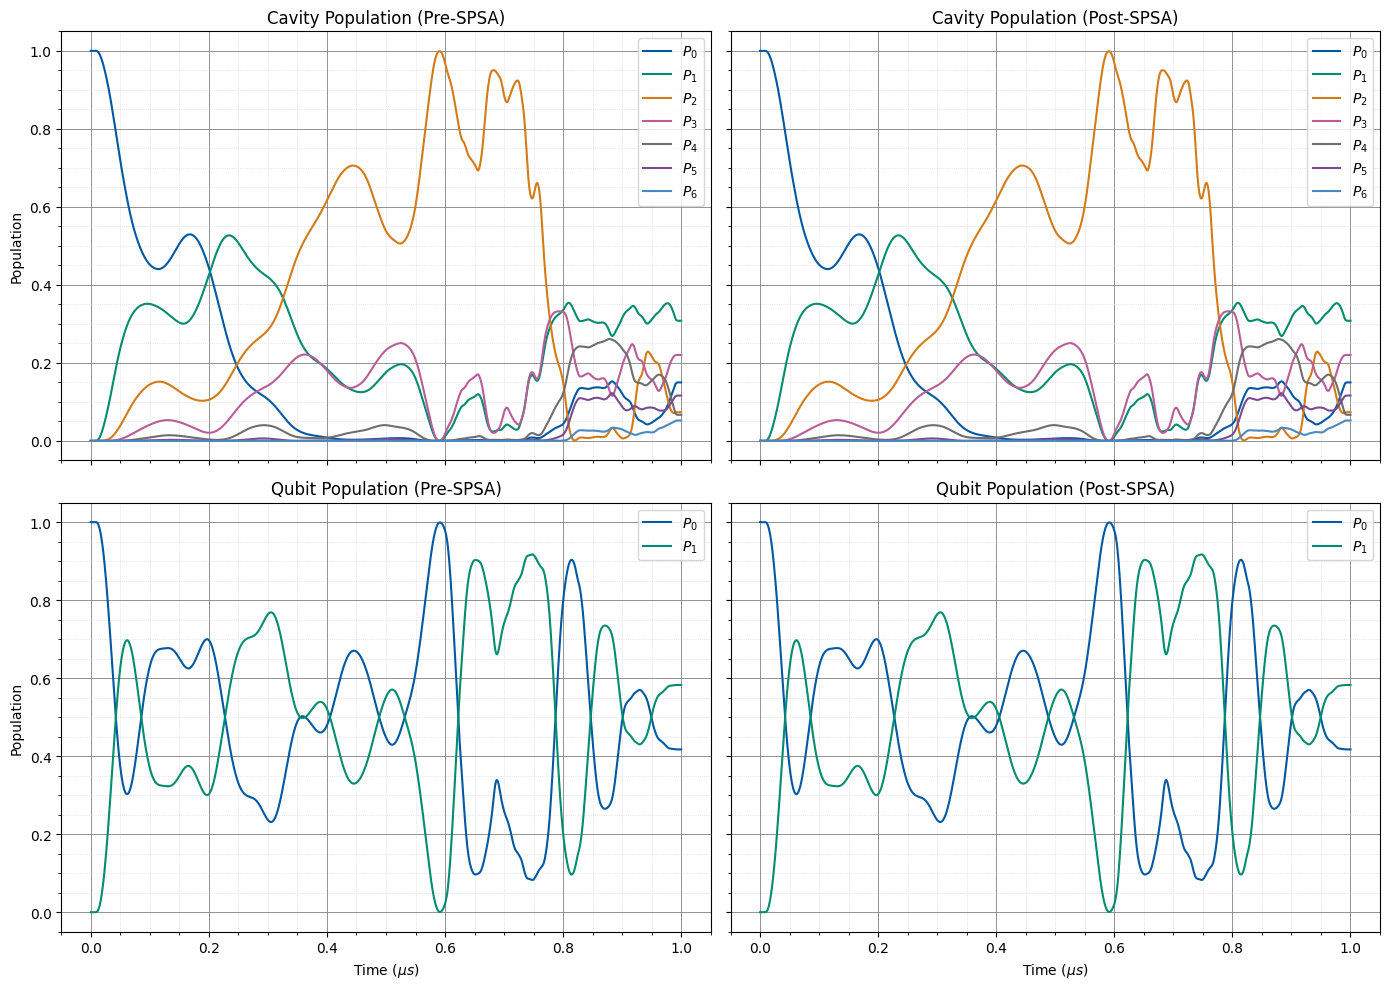

In [36]:
colors = [
    "#0058A3",
    "#008C6E",
    "#D47A17",
    "#B95D99",
    "#6E6E6E",
    "#7A4A91",
    "#4A89C0",
    # "#C04851",
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey='row')

# --- Top-Left: Cavity Population (Generated Pulse) ---
ax = axes[0, 0]
for j, c in enumerate(colors):
    ax.plot(tsave, prob_sim_gen[j, :], '-', label=f'$P_{j}$', color=c)
ax.set_title('Cavity Population (Pre-SPSA)')
ax.set_ylabel('Population')
ax.legend()

# --- Top-Right: Cavity Population (SPSA Pulse) ---
ax = axes[0, 1]
for j, c in enumerate(colors):
    ax.plot(tsave, prob_sim_spsa[j, :], '-', label=f'$P_{j}$', color=c)
ax.set_title('Cavity Population (Post-SPSA)')
ax.legend()

# --- Bottom-Left: Qubit Population (Generated Pulse) ---
ax = axes[1, 0]
for j in range(ntr):
    ax.plot(tsave, prob_qb_sim_gen[j, :], '-', label=f'$P_{j}$', color=colors[j])
ax.set_title('Qubit Population (Pre-SPSA)')
ax.set_ylabel('Population')
ax.set_xlabel('Time ($\\mu s$)')
ax.legend()

# --- Bottom-Right: Qubit Population (SPSA Pulse) ---
ax = axes[1, 1]
for j in range(ntr):
    ax.plot(tsave, prob_qb_sim_spsa[j, :], '-', label=f'$P_{j}$', color=colors[j])
ax.set_title('Qubit Population (Post-SPSA)')
ax.set_xlabel('Time ($\\mu s$)')
ax.legend()

# Apply grids to all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.grid(True, which='major', linestyle='-', linewidth='0.6', color='gray')
        ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
        ax.minorticks_on() 
        

plt.tight_layout()

In [ ]:
# We should also have a comparison of before and after pulse shapes for SPSA
%matplotlib inline
print("Verifying the pre-trained pulse...")

# Prepare the time vector input for the model
time_array = my_params['tpulse'][:-1]
time_input = tf.constant(time_array, dtype=tf.float64)
time_input = tf.reshape(time_input, (1, len(time_array), 1))


# Numerically compare by calculating the Mean Squared Error
mse = np.mean(np.abs(np.square(generated_pulse_np - ideal_pulse_complex)))
print(f"Mean Squared Error (NN vs Ideal): {mse:.6f}")

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(gen_pulse[0, :]), 'b-', label='Sim (Re)')
axs[0].plot(time_array, np.imag(gen_pulse[0, :]), 'r-', label='Sim (Im)')
axs[0].plot(time_array, np.real(spsa_pulse[0, :]), 'b--', label='SPSA (Re)')
axs[0].plot(time_array, np.imag(spsa_pulse[0, :]), 'r--', label='SPSA (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(gen_pulse[1, :]), 'b-', label='Sim (Re)')
axs[1].plot(time_array, np.imag(gen_pulse[1, :]), 'r-', label='Sim (Im)')
axs[1].plot(time_array, np.real(spsa_pulse[1, :]), 'b--', label='SPSA (Re)')
axs[1].plot(time_array, np.imag(spsa_pulse[1, :]), 'r--', label='SPSA (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

%matplotlib qt

### Wigner & fidelity check:

In [30]:
# Load the optimizer and SPSA optimized pulse
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer.load_model_weights(directory + 'spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5')
print('\nModel loaded, proceed to SPSA hardware tuning')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5

Model loaded, proceed to SPSA hardware tuning


In [129]:
# my_test_params = my_params.copy()

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = (-0.0242 + 0.0 ) * (2 * np.pi)
chi = (-3.649 - 0.01) * (2 * np.pi)
chi_prime = (+0.039 - 0.0) * (2 * np.pi)

# Detuning on qubit and cavity drives
det_osc = 0.015*(2*np.pi)
det_qb = -0.015*(2*np.pi)

T1q = 70
T2q = 30
Tphiq = (1/T2q - 1/(2*T1q))**(-1)

T1c = 200
T2c = 280
Tphic = (1/T2c - 1/(2*T1c))**(-1)

c_ops = [
        jnp.sqrt(1/T1q)*dq.tensor(idcav, t),
        jnp.sqrt(1/Tphiq)*dq.tensor(idcav, tdag @ t),
        jnp.sqrt(1/T1c)*dq.tensor(a, idtr), 
        jnp.sqrt(1/Tphic)*dq.tensor(adag @ a, idtr),
        ]

params = my_test_params.copy()

a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
idcav = dq.eye(params['ncav'])
idtr = dq.eye(params['ntr'])

if params['osc_drive'] == 'linear':
    osc_pow = 1
elif params['osc_drive']=='squeeze':
    osc_pow = 2

# Add noise to the drive
# iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
# amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
# amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

# noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
noisy_amps = optimizer.generate_pulse()

# Add detuning to the drives
qb_det_phi = det_qb * params['tpulse'][:-1]
osc_det_phi = det_osc * params['tpulse'][:-1]
det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

# time-dependent Hamiltonian
# (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
H = my_test_params['H0'] + Hcr + Hci + Htr + Hti

options = dq.Options(progress_meter = None)
solver = dq.method.Tsit5(max_steps = int(1e9))

evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
# evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)

osc_states = dq.ptrace(evo_result.states[0,:], dims = (params['ncav'], params['ntr']), keep = (0,))

Generating pulse from the trained model...


In [130]:
utl.compute_fidelity_loss(evo_result)
cat_state = (dq.coherent(ncav, 2.2) + dq.coherent(ncav, -2.2)).unit()
cat_state_dm = cat_state @ cat_state.dag()
dq.trace(osc_states[-1] @ cat_state_dm)

Array(0.96019+1.395506e-10j, dtype=complex64)

In [132]:
dq.plot.wigner(osc_states[-1], xmax = 3.5)
# plt.plot(sampled_coords[:,0], sampled_coords[:,1], 'k*')

In [75]:
dq.plot.wigner(cat_state, xmax = 3.8)
plt.plot(sampled_coords[:,0], sampled_coords[:,1], 'k*')

### robustness check: 

In [ ]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer2 = HardwareAwareOptimizer(my_test_params, fourier_scale = 12)
optimizer2.load_model_weights(directory + 'SPSA_tuned_model.weights.h5')

optimizer = HardwareAwareOptimizer(my_test_params, fourier_scale = 12)
optimizer.load_model_weights(directory + 'SPSA_tuned_model_non_robust.weights.h5')
print('\nModels loaded')

In [ ]:
def chi_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    
    orig_H0 = params['H0'] + Hcr + Hci + Htr + Hti
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, det in enumerate(dets): 
        H = orig_H0 + det * dq.tensor(a @ adag, t @ tdag)
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [ ]:
# ### Check robustness of the fine-tuned pulse: 
chi_dets = np.linspace(-0.25, 0.25, 11)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = chi_robustness(rob_pulse, chi_dets, my_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = chi_robustness(gen_pulse, chi_dets, my_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [ ]:
plt.figure()
plt.plot(chi_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(chi_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Chi Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

In [ ]:
def qb_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))

    orig_H0 = params['H0'] + Hcr + Hci 
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, qb_det in enumerate(dets):
        
        qb_det_phase = qb_det * params['tpulse'][:-1]
        phasor = jnp.exp(-1j * qb_det_phase) 
        qb_amp = amps[1,:]*phasor

        Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(qb_amp)), dq.tensor(idcav, t+tdag))
        Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(qb_amp)), -1j * dq.tensor(idcav, (t - tdag)))
        
        H = orig_H0 + Htr + Hti
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [ ]:
# ### Check robustness of the fine-tuned pulse: 
qb_dets = np.linspace(-0.95, 0.95, 21)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = qb_robustness(rob_pulse, qb_dets, my_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = qb_robustness(gen_pulse, qb_dets, my_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [ ]:
plt.figure()
plt.plot(qb_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(qb_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Qubit Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

## Wigner sampling test:

Starting rejection sampling to find 20 points...
Sampling complete.


--- Optimizer Loss Value ---
Average Reward: 0.2905
Fidelity Estimate (F): 0.9125
Final Loss (1 - F): 0.0875


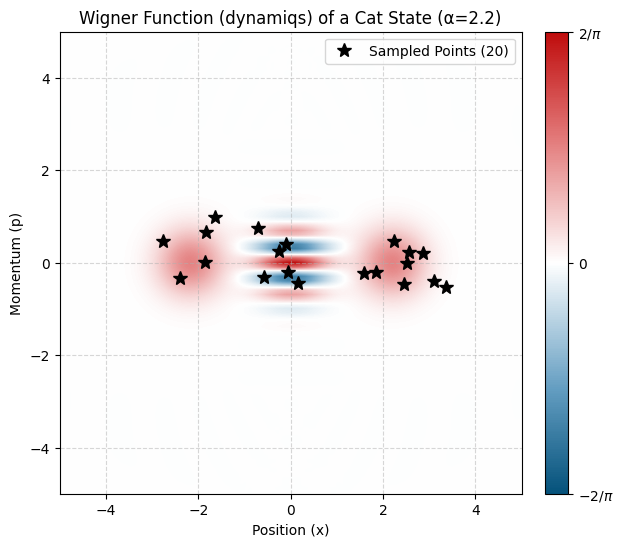

In [10]:
%matplotlib inline
# Define parameters for the simulation
N = 30  # Hilbert space dimension
alpha_val = 2.2  # Amplitude of the coherent states
num_points_to_sample = 20 # Number of points to sample in phase space

# Define the phase space grid for plotting and normalization
x_vec = jnp.linspace(-6, 6, 201)
p_vec = jnp.linspace(-6, 6, 201)

# Create the cat state |psi> using dynamiqs
psi = (dq.coherent(N, alpha_val) + dq.coherent(N, -alpha_val)).unit()

# Calculate the Wigner function on the grid using dynamiqs
W_psi_dq = dq.wigner(state = psi, xvec = x_vec, yvec = p_vec)
W_psi_np = np.asarray(W_psi_dq[2])  # Convert to NumPy for non-JAX operations

# --- Rejection Sampling ---
# Find the maximum absolute value of the Wigner function
w_abs_max = np.max(np.abs(W_psi_np))

accepted_points = []
print(f"Starting rejection sampling to find {num_points_to_sample} points...")

while len(accepted_points) < num_points_to_sample:
    # Propose a random point from a uniform distribution
    x_sample = np.random.uniform(x_vec.min(), x_vec.max())
    p_sample = np.random.uniform(p_vec.min(), p_vec.max())
    
    # Calculate Wigner value at the sampled point using dynamiqs
    w_val_at_sample = jnp.diag(dq.wigner(psi, xvec = jnp.array([x_sample]), yvec = jnp.array([p_sample]))[2])
    
    # Acceptance condition
    u = np.random.uniform(0, w_abs_max)
    if u <= np.abs(w_val_at_sample):
        accepted_points.append({'x': x_sample, 'p': p_sample, 'w_val': float(w_val_at_sample[0])})
        # if len(accepted_points) % (num_points_to_sample // 10) == 0:
        #      print(f"  Accepted point {len(accepted_points)}/{num_points_to_sample}")

print("Sampling complete.\n")

# --- Reward Calculation ---
# Normalize the probability distribution P(alpha) = |W(alpha)| / Z
dx = x_vec[1] - x_vec[0]
dp = p_vec[1] - p_vec[0]
purity_integral = np.sum(W_psi_np**2) * dx * dp
A = 1.0 / purity_integral
Z = np.sum(np.abs(W_psi_np)) * dx * dp

c = 1.0  # Assume the constant c=1

for point in accepted_points:
    wigner_val = point['w_val']
    P_alpha = np.abs(wigner_val) / Z
    
    if P_alpha > 1e-12:
      R_alpha = (c * wigner_val) / P_alpha
    else:
      R_alpha = 0
    
    point['reward'] = wigner_val * R_alpha

# --- Final Loss Calculation for Optimizer ---
all_rewards = [p['reward'] for p in accepted_points]
average_reward = np.mean(all_rewards)

# Fidelity estimate for pure dynamiqs normalization requires a pi/2 prefactor.
# The estimator is F = (pi/2) * (1/Ns) * sum( (Wt*Wm)/P )
# This resolves to F = (pi / (4*c)) * average_reward
# fidelity_estimate = (np.pi / (4 * c)) * average_reward
# loss = 1.0 - fidelity_estimate
fidelity_estimate = (A / c) * average_reward
loss = 1.0 - fidelity_estimate

print("\n--- Optimizer Loss Value ---")
print(f"Average Reward: {average_reward:.4f}")
print(f"Fidelity Estimate (F): {fidelity_estimate:.4f}")
print(f"Final Loss (1 - F): {loss:.4f}")

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
dq.plot.wigner(psi, ax = ax)

points_x = [p['x'] for p in accepted_points]
points_p = [p['p'] for p in accepted_points]
ax.plot(points_x, points_p, 'k*', markersize=10, label=f'Sampled Points ({num_points_to_sample})')

ax.set_xlabel('Position (x)')
ax.set_ylabel('Momentum (p)')
ax.set_title(f'Wigner Function (dynamiqs) of a Cat State (α={alpha_val})')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [11]:
sampled_coords = np.array([[point['x'], point['p']] for point in accepted_points])
sampled_coords

array([[ 3.35989003, -0.53186922],
       [ 2.44615671, -0.4545055 ],
       [-2.39487239, -0.32953784],
       [-1.62804425,  0.97927919],
       [ 2.56728259,  0.23139996],
       [-0.7127932 ,  0.74869222],
       [ 3.10254272, -0.39348588],
       [-0.06794239, -0.20922047],
       [ 2.86374366,  0.21752809],
       [ 2.22904144,  0.46110908],
       [-1.84270237,  0.66967333],
       [-0.10426243,  0.40574273],
       [-2.75969405,  0.47796131],
       [-1.86000299,  0.00797902],
       [-0.58203197, -0.30719464],
       [ 0.15576681, -0.43217209],
       [ 1.58348466, -0.2169091 ],
       [ 2.51690581,  0.00457117],
       [-0.25587613,  0.25124493],
       [ 1.85264774, -0.20899442]])

In [12]:
w_target_vals = np.array([point['w_val'] for point in accepted_points])
w_target_vals

array([ 0.01226199,  0.18653452,  0.23741275,  0.02398347,  0.21834469,
        0.0728754 ,  0.04579319, -0.15428194,  0.11996661,  0.20767485,
        0.10082588, -0.40750393,  0.10772195,  0.25318524, -0.24099085,
       -0.32929593,  0.13418511,  0.26036119, -0.29386392,  0.22897051])

In [26]:
my_params['sampled_coords'] = sampled_coords
my_params['w_target_vals'] = w_target_vals

In [ ]:
def spsa_loss_wigner_sampling(amps, params):
    """
    Loss calculator for SPSA using importance sampling of the Wigner function.
    This function is designed to be consistent with the pre-sampling script
    'wigner_sampling_dynamiqs.py'.
    """
    # Unpack necessary parameters from the params dictionary
    ncav = params['ncav']
    ntr = params['ntr']
    H0 = params['H0']
    psi0 = params['psi0']
    tpulse = params['tpulse']
    tsave = params['tsave']
    osc_drive = params.get('osc_drive', 'linear') # Default to linear drive
    
    # Pre-sampled data for fidelity estimation
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    Z = params['Z']
    A = params['A']
    c = params.get('c', 1.0) # Reward constant, default to 1.0

    # Define operators
    a, adag = dq.destroy(ncav), dq.create(ncav)
    t, tdag = dq.destroy(ntr), dq.create(ntr)
    idcav = dq.eye(ncav)
    idtr = dq.eye(ntr)

    osc_pow = 1 if osc_drive == 'linear' else 2

    # Construct time-dependent Hamiltonian from control amplitudes
    # Note: Noise terms from the original example are omitted for clarity,
    # but can be re-introduced here if needed.
    Hcr = dq.pwc(tpulse, amps[0, :], dq.tensor(dq.powm(a, osc_pow) + dq.powm(adag, osc_pow), idtr))
    Hci = dq.pwc(tpulse, amps[1, :], -1j * dq.tensor((dq.powm(a, osc_pow) - dq.powm(adag, osc_pow)), idtr))
    Htr = dq.pwc(tpulse, amps[2, :], dq.tensor(idcav, t + tdag))
    Hti = dq.pwc(tpulse, amps[3, :], -1j * dq.tensor(idcav, t - tdag))
    H = H0 + Hcr + Hci + Htr + Hti

    # Define solver options
    options = dq.Options(progress_meter=None)
    solver = dq.solver.Tsit5()

    # Evolve the initial state
    evo_result = dq.sesolve(H, psi0, tsave, options=options, solver=solver)
    final_state = evo_result.states[-1]

    # --- Fidelity Estimation via Importance Sampling ---

    # Measure the Wigner function of the final state at the pre-sampled coordinates
    x_coords = jnp.array(sampled_coords[:, 0])
    p_coords = jnp.array(sampled_coords[:, 1])
    # The result of dq.wigner is a grid; we need the diagonal elements W(x_i, p_i)
    w_measured_grid = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_measured_vals = jnp.diag(w_measured_grid)

    # Calculate rewards using the convention from the sampling script
    P_alphas = jnp.abs(w_target_vals) / Z
    R_alphas = jnp.where(
        P_alphas > 1e-12,
        (c * w_target_vals) / P_alphas,
        0.0
    )
    all_rewards = w_measured_vals * R_alphas

    # # Calculate final loss from the average reward and the numerical prefactor A
    # average_reward = jnp.mean(all_rewards)
    # fidelity_estimate = (A / c) * average_reward
    # loss = 1.0 - fidelity_estimate

    return 1/all_rewards

Starting rejection sampling to find 20 points...
Sampling complete.


--- Final Reward Value ---
Average Reward: 0.3075


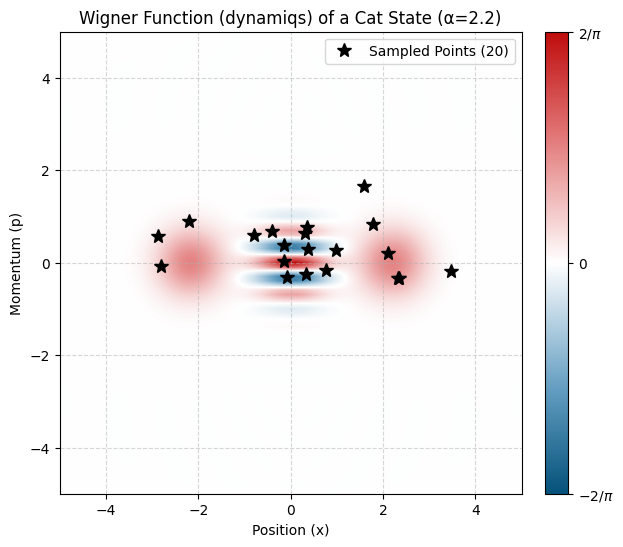

In [24]:
%matplotlib inline
# Define parameters for the simulation
N = 30  # Hilbert space dimension
alpha_val = 2.2  # Amplitude of the coherent states
num_points_to_sample = 20 # Number of points to sample in phase space

# Define the phase space grid for plotting and normalization
x_vec = jnp.linspace(-6, 6, 201)
p_vec = jnp.linspace(-6, 6, 201)

# Create the cat state |psi> using dynamiqs
psi = (dq.coherent(N, alpha_val) + dq.coherent(N, -alpha_val)).unit()

# Calculate the Wigner function on the grid using dynamiqs
W_psi_dq = dq.wigner(state = psi, xvec = x_vec, yvec = p_vec)
W_psi_np = np.asarray(W_psi_dq[2])  # Convert to NumPy for non-JAX operations

# --- Rejection Sampling ---
# Find the maximum absolute value of the Wigner function
w_abs_max = np.max(np.abs(W_psi_np))

accepted_points = []
print(f"Starting rejection sampling to find {num_points_to_sample} points...")

while len(accepted_points) < num_points_to_sample:
    # Propose a random point from a uniform distribution
    x_sample = np.random.uniform(x_vec.min(), x_vec.max())
    p_sample = np.random.uniform(p_vec.min(), p_vec.max())
    
    # Calculate Wigner value at the sampled point using dynamiqs
    w_val_at_sample = jnp.diag(dq.wigner(psi, xvec = jnp.array([x_sample]), yvec = jnp.array([p_sample]))[2])
    
    # Acceptance condition
    u = np.random.uniform(0, w_abs_max)
    if u <= np.abs(w_val_at_sample):
        accepted_points.append({'x': x_sample, 'p': p_sample, 'w_val': float(w_val_at_sample[0])})

print("Sampling complete.\n")

# --- Reward Calculation ---
# Normalization constant for the probability distribution P(alpha) = |W(alpha)| / Z
dx = x_vec[1] - x_vec[0]
dp = p_vec[1] - p_vec[0]
Z = np.sum(np.abs(W_psi_np)) * dx * dp

c = 1.0  # Assume the constant c=1

for point in accepted_points:
    wigner_val = point['w_val']
    P_alpha = np.abs(wigner_val) / Z
    
    # The reward function R(alpha)
    if P_alpha > 1e-12:
      R_alpha = (c * wigner_val) / P_alpha
    else:
      R_alpha = 0
    
    # Store the specific reward for this sampled point, which is W(alpha) * R(alpha)
    point['reward'] = wigner_val * R_alpha

# --- Final Reward Calculation ---
all_rewards = [p['reward'] for p in accepted_points]
average_reward = np.mean(all_rewards)

print("\n--- Final Reward Value ---")
print(f"Average Reward: {average_reward:.4f}")

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
dq.plot.wigner(psi, ax = ax)

points_x = [p['x'] for p in accepted_points]
points_p = [p['p'] for p in accepted_points]
ax.plot(points_x, points_p, 'k*', markersize=10, label=f'Sampled Points ({num_points_to_sample})')

ax.set_xlabel('Position (x)')
ax.set_ylabel('Momentum (p)')
ax.set_title(f'Wigner Function (dynamiqs) of a Cat State (α={alpha_val})')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [49]:
def spsa_wigner_loss_calculator(amps, params):
    # Part 1: Evolve the state using the input pulse
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])

    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))
    
    evo_result = dq.sesolve(H, params['psi0'][0], params['tsave'], options=options, method=solver)
    final_state = evo_result.states[-1]

    # Part 2: Calculate reward using the pre-sampled points and target values
    # sampled_coords = params['sampled_coords']
    # w_target_vals = params['w_target_vals']
    
    # Extract x and p coordinates for the batch Wigner calculation
    x_coords = sampled_coords[:, 0]
    p_coords = sampled_coords[:, 1]
    
    # Calculate Wigner values of the evolved state at the sampled points
    w_evolved_dq = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_evolved_vals = jnp.diag(w_evolved_dq[2])

    # The reward for each point is the product of the evolved and target Wigner values
    rewards = w_evolved_vals * w_target_vals
    average_reward = jnp.mean(jnp.abs(rewards))
    
    # The loss is defined as the inverse of the average reward
    loss = 1.0 / average_reward

    return loss

# GKP State:

## Pre-training:

In [ ]:
# Load a pulse obtained from gradient descent
# It should be a numpy array of shape (4, n_pulse_points)
print("Loading a sample pulse for pre-training...")

directory = '/Users/saswataroy/OptimalControl/pulses/'
data = np.load(directory + 'fock_2_prep.npz')
amps = data["arr_0"]

ideal_pulse = amps

print("Sample pulse loaded.")

Loading a sample pulse for pre-training...
Sample pulse loaded.


In [ ]:
# DEFINE SIMULATION AND PHYSICS PARAMETERS
fourier_scale = 15
# Instantiate the main optimizer class
# Define the scaling factors for the output layer.
# These values multiply the standard Glorot-initialized weights.
# Format: (I_cavity, Q_cavity, I_qubit, Q_qubit)
init_scales = (8.0, 8.0, 18.0, 18.0)

# Simulation parameters
osc_drive_type = 'linear'
ncav = 20  # Hilbert space dimension for the oscillator
ntr = 2    # Hilbert space dimension for the transmon

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = -0.0242 * (2 * np.pi)
chi = -3.649 * (2 * np.pi)
chi_prime = +0.039 * (2 * np.pi)

# Pulse parameters
T = 1 # Total pulse time in microseconds
ntsave = 1001
ntpulse = 1001
max_amp = 5 * np.pi * 2 # Max amplitude for the drives
max_freq = 25 # Max frequency component in MHz (+- max_freq is allowed)

# SETUP HAMILTONIAN, STATES, AND OPERATORS ---
# Operators
a, adag = dq.destroy(ncav), dq.create(ncav)
t, tdag = dq.destroy(ntr), dq.create(ntr)
idcav, idtr = dq.eye(ncav), dq.eye(ntr)

# Define Binomial codewords and errorwords
L0 = (dq.basis(ncav, 0) + dq.basis(ncav, 4)) / jnp.sqrt(2)
L1 = dq.basis(ncav, 2)

plus_X = dq.unit((L0 + L1) / jnp.sqrt(2)) 
minus_X = dq.unit((L0 - L1) / jnp.sqrt(2))
plus_Y = dq.unit((L0 + 1j*L1) / jnp.sqrt(2)) 
minus_Y = dq.unit((L0 - 1j*L1) / jnp.sqrt(2))

# Error words:
E0 = dq.basis(ncav, 3)
E1 = dq.basis(ncav, 1)
E_plus_X = dq.unit((E0 + E1) / jnp.sqrt(2))
E_minus_X = dq.unit((E0 - E1) / jnp.sqrt(2))
E_plus_Y = dq.unit((E0 + 1j*E1) / jnp.sqrt(2))
E_minus_Y = dq.unit((E0 - 1j*E1) / jnp.sqrt(2))

targ_state = dq.unit(dq.coherent(ncav,2.2) + dq.coherent(ncav, -2.2))

psi0 = [dq.tensor(dq.basis(ncav,0), dq.basis(ntr,0))]

exp_ops = [dq.tensor(dq.proj(targ_state), dq.proj(dq.basis(ntr,0)))]

# Time arrays
tsave = jnp.linspace(0.0, T, ntsave, dtype = jnp.float32)
tpulse = jnp.linspace(0.0, T, ntpulse, dtype = jnp.float32)

# Static Hamiltonian
H0 = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
     (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t)

# Create the master parameter dictionary
my_params = {'H0': H0, 
             'ncav': ncav, 
             'ntr': ntr, 
             'alpha': alpha, 
             'K': K, 
             'chi': chi,
             'chi_prime': chi_prime, 
             'T': T, 
             'ntsave': ntsave, 
             'ntpulse': ntpulse,
             'max_amp': max_amp, 
             'max_freq': max_freq, 
             'psi0': psi0, 
             'exp_ops': exp_ops, 
             'tsave': tsave, 
             'tpulse': tpulse, 
             'osc_drive': osc_drive_type,
             'fourier_scale':fourier_scale,
             'init_scales':init_scales}

In [ ]:
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

Initializing Optimizer...
Neural network model created.


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,  # How often to decay
    decay_rate=0.95)   # How much to decay by

# Pre-train the network on the GRADIENT descent generated pulse
optimizer.pre_train(
    ideal_pulse_arrays=ideal_pulse,
    time_array=my_params['tpulse'][:-1],
    epochs= 75000,
    learning_rate=1e-3
)

NameError: name 'ideal_pulse' is not defined

Verifying the pre-trained pulse...
Generating pulse from the trained model...
Mean Squared Error (NN vs Ideal): 152.735471


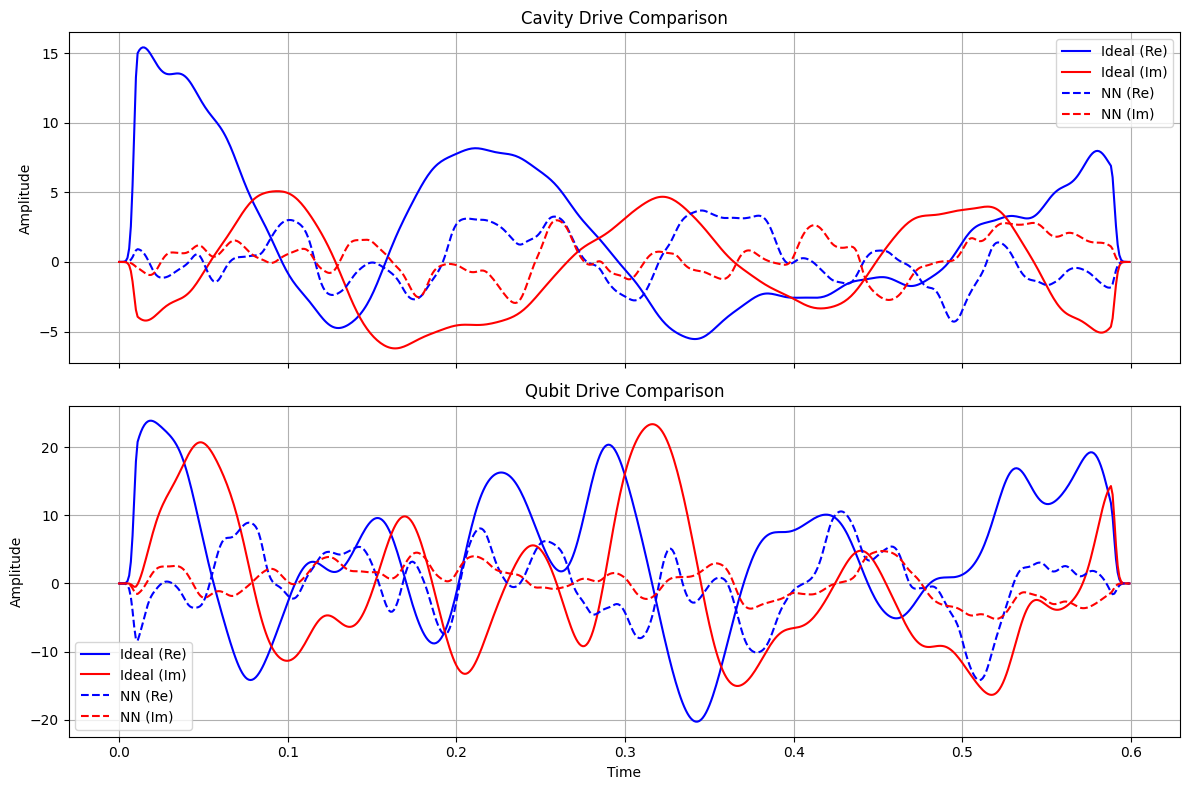

In [ ]:
%matplotlib inline
print("Verifying the pre-trained pulse...")

# Prepare the time vector input for the model
time_array = my_params['tpulse'][:-1]
time_input = tf.constant(time_array, dtype=tf.float64)
time_input = tf.reshape(time_input, (1, len(time_array), 1))

# Generate a pulse from the trained network
generated_pulse_np = optimizer.generate_pulse()

ideal_pulse_complex = amps

# Numerically compare by calculating the Mean Squared Error
mse = np.mean(np.abs(np.square(generated_pulse_np - ideal_pulse_complex)))
print(f"Mean Squared Error (NN vs Ideal): {mse:.6f}")

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(ideal_pulse_complex[0, :]), 'b-', label='Ideal (Re)')
axs[0].plot(time_array, np.imag(ideal_pulse_complex[0, :]), 'r-', label='Ideal (Im)')
axs[0].plot(time_array, np.real(generated_pulse_np[0, :]), 'b--', label='NN (Re)')
axs[0].plot(time_array, np.imag(generated_pulse_np[0, :]), 'r--', label='NN (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(ideal_pulse_complex[1, :]), 'b-', label='Ideal (Re)')
axs[1].plot(time_array, np.imag(ideal_pulse_complex[1, :]), 'r-', label='Ideal (Im)')
axs[1].plot(time_array, np.real(generated_pulse_np[1, :]), 'b--', label='NN (Re)')
axs[1].plot(time_array, np.imag(generated_pulse_np[1, :]), 'r--', label='NN (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

%matplotlib qt

In [ ]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'pretrained_gkp'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/fock2_pretrained_model.weights.h5


## Offline Training:

In [ ]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)
optimizer.load_model_weights(directory + 'fock2_fine_tuned_model_chi_qb_robust.weights.h5')
print('\n Model loaded, pre-training skipped')

# Or Initialize the optimizer:
# optimizer = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/fock2_fine_tuned_model_chi_qb_robust.weights.h5

 Model loaded, pre-training skipped


In [ ]:
def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

# Check the performance of pulse generated by a loaded model
print(loss_calculator_func(optimizer.generate_pulse(), my_params))

Generating pulse from the trained model...
0.0010169148


In [ ]:
# Run the optimizer
optimizer.fine_tune_simulation(
    loss_calculator_func=loss_calculator_func,
    epochs=30000,
    learning_rate=5e-4
)


--- Starting Simulation Fine-tuning ---


Sim-tuning:   2%|▏         | 734/30000 [07:49<5:11:48,  1.56it/s]


Target fidelity loss of 0.001 reached at epoch 734. Stopping fine-tuning.
Simulation fine-tuning finished. Final Fidelity Loss: 0.000991


In [ ]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'offline_trained_cat'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.weights.h5
'/Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.npz'

Trained model is saved and ready for hardware SPSA tuning


In [ ]:
gen_pulse = optimizer.generate_pulse()
spsa_pulse = gen_pulse

Generating pulse from the trained model...


### Robustness calculation: 

In [ ]:
def build_robustness_tensors(params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav, idtr = dq.eye(params['ncav']), dq.eye(params['ntr'])

    # Define variations in MHz
    chi_variations_mhz = jnp.array([-3.649, -3.649 - 0.015, -3.649 + 0.015], dtype=jnp.float32)
    qb_dets_variations_mhz = jnp.array([0, -0.1, +0.1], dtype=jnp.float32)

    # Get constant parameters
    alpha = jnp.float32(params['alpha'])
    chi_prime = jnp.float32(params['chi_prime'])
    K = jnp.float32(params['K'])
    pi_32 = jnp.float32(jnp.pi)

    # Build a Batch of the static Hamiltonians and detuning phasors
    H0_batch_list = []
    qbdet_batch_list = []
    
    for chi_mhz in chi_variations_mhz:
        for qb_det_mhz in qb_dets_variations_mhz:
            chi = chi_mhz * (2 * pi_32)
            H0_sample = (chi * dq.tensor(adag @ a, tdag @ t) +
                         (K / 2) * dq.tensor(adag @ adag @ a @ a, idtr) +
                         (alpha / 2) * dq.tensor(idcav, tdag @ tdag @ t @ t) +
                         (chi_prime / 2) * dq.tensor(adag @ adag @ a @ a, tdag @ t))
            H0_batch_list.append(H0_sample)

            qb_det = qb_det_mhz * (2 * pi_32)
            qb_det_phase = qb_det * params['tpulse'][:-1]
            phasor = jnp.exp(-1j * qb_det_phase)
            qbdet_batch_list.append(phasor)

    return {
        'H0_batch': dq.stack(H0_batch_list),
        'qbdet_batch': jnp.stack(qbdet_batch_list)
    }

robustness_tensors = build_robustness_tensors(my_params)
my_params.update(robustness_tensors)

In [ ]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, fourier_scale = 12)
optimizer.load_model_weights(directory + 'offline_trained_fock2_noseed_2025-09-14_16-14-46.weights.h5')
print('\n Model loaded, pre-training skipped')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_noseed_2025-09-14_16-14-46.weights.h5

 Model loaded, pre-training skipped


In [ ]:
def robust_loss_calculator(amps, params, robustness_weight=0.9):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav, idtr = dq.eye(params['ncav']), dq.eye(params['ntr'])
    psi0, tsave, exp_ops = params['psi0'], params['tsave'], params['exp_ops']
    
    # Fetch pre-calculated tensors from the params dictionary
    H0_batch = params['H0_batch']
    qbdet_batch = params['qbdet_batch']
    
    # Build the time-dependent part of the Hamiltonian
    if params['osc_drive'] == 'linear': osc_pow = 1
    else: osc_pow = 2
    
    det_qb_drive_batch = amps[1,:] * qbdet_batch  # Broadcasting (B, N) = (N,) * (B, N)

    # Broadcast the common cavity drive to match the batch shape
    cavity_drive_amps = amps[0,:]
    cavity_drive_amps_batch = jnp.broadcast_to(cavity_drive_amps, det_qb_drive_batch.shape)

    # Construct the full batched Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(cavity_drive_amps_batch), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.imag(cavity_drive_amps_batch), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(det_qb_drive_batch), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.imag(det_qb_drive_batch), -1j * dq.tensor(idcav, (t - tdag)))

    H_total_batch = H0_batch + Hcr + Hci + Htr + Hti

    # Perform Simulation and Calculate Loss
    options = dq.Options(progress_meter=None)
    solver = dq.method.Tsit5(max_steps=int(1e9))
    batch_evo_result = dq.sesolve(
        H_total_batch, psi0, tsave, exp_ops=exp_ops, options=options, method=solver
    )

    all_expects_final = batch_evo_result.expects[...,-1].real
    num_psi = all_expects_final.shape[1]

    traces = jnp.trace(all_expects_final, axis1=1, axis2=2)
    central_fidelity = traces[0] / num_psi
    robust_fidelity = jnp.mean(traces) / num_psi
    
    weighted_fidelity = (central_fidelity + robustness_weight * robust_fidelity) / (1 + robustness_weight)
    
    # if central_fidelity > 0.999:
    #     total_infidelity = 1 - central_fidelity
    # else:
    #     total_infidelity = 1.0 - weighted_fidelity
    
    total_infidelity = 1 - weighted_fidelity

    return jnp.real(total_infidelity)

In [ ]:
# %matplotlib qt
# mpl.rcParams['figure.raise_window'] = False

optimizer.fine_tune_simulation(
    loss_calculator_func=robust_loss_calculator,
    epochs=15000,
    learning_rate=4e-4, 
    update_plot_every = 25
)


--- Starting Simulation Fine-tuning ---


Sim-tuning:   5%|▌         | 778/15000 [39:13<11:57:06,  3.03s/it] 


Target fidelity loss of 0.001 reached at epoch 778. Stopping fine-tuning.
Simulation fine-tuning finished. Final Fidelity Loss: 0.000999


In [ ]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'offline_trained_fock2_robust_chi_qbdet'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")


Saving the fine-tuned model weights...
Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/fock2_fine_tuned_model_chi_qb_robust.weights.h5

 Fine-tuned model is saved and ready for SPSA.


## SPSA testing in simulation:

In [ ]:
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer.load_model_weights(directory + 'offline_trained_cat_2025-10-14_16-59-38.weights.h5')
print('\nModel loaded, proceed to SPSA hardware tuning')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-10-14_16-59-38.weights.h5

Model loaded, proceed to SPSA hardware tuning


In [ ]:
# Optional: Sanity check: check the fidelity of the loaded pulse
loss_calculator_func(optimizer.generate_pulse(), my_params)

Generating pulse from the trained model...


Array(0.00101691, dtype=float32)

In [ ]:
my_test_params = my_params.copy()

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = (-0.0242 + 0.0 ) * (2 * np.pi)
chi = (-3.649 - 0.01) * (2 * np.pi)
chi_prime = (+0.039 - 0.0) * (2 * np.pi)

# Detuning on qubit and cavity drives
det_osc = 0.015*(2*np.pi)
det_qb = -0.015*(2*np.pi)

my_test_params['H0'] = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
        (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t)

my_test_params['sampled_coords'] = sampled_coords  
my_test_params['w_target_vals'] = w_target_vals
my_test_params['A'] = A
my_test_params['Z'] = Z
my_test_params['c'] = 1.0

def spsa_test_loss_calculator(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    # add measurement noise to fidelity calculation
    measurement_noise = 0.0*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def spsa_loss_wigner_sampling(amps, params):
    """
    Loss calculator for SPSA using importance sampling of the Wigner function.
    This function is designed to be consistent with the pre-sampling script
    'wigner_sampling_dynamiqs.py'.
    """
    # Unpack necessary parameters from the params dictionary
    
    # Pre-sampled data for fidelity estimation
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    Z = params['Z']
    A = params['A']
    c = params.get('c', 1.0) # Reward constant, default to 1.0


    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    final_state = dq.ptrace(evo_result.states[0,-1], dims = (params['ncav'], params['ntr']), keep=(0,))

    # # --- Fidelity Estimation via Importance Sampling ---

    # # Measure the Wigner function of the final state at the pre-sampled coordinates
    x_coords = jnp.array(sampled_coords[:, 0])
    p_coords = jnp.array(sampled_coords[:, 1])
    # The result of dq.wigner is a grid; we need the diagonal elements W(x_i, p_i)
    w_measured_grid = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_measured_vals = jnp.diag(w_measured_grid[2])

    loss_values = jnp.abs(w_target_vals - w_measured_vals)**2
    loss = jnp.mean(loss_values)

    # # Calculate rewards using the convention from the sampling script
    # P_alphas = jnp.abs(w_target_vals) / Z
    # R_alphas = jnp.where(
    #     P_alphas > 1e-12,
    #     (c * w_target_vals) / P_alphas,
    #     0.0
    # )
    # all_rewards = w_measured_vals * R_alphas

    # # Calculate final loss from the average reward and the numerical prefactor A
    # average_reward = jnp.mean(all_rewards)
    # fidelity_estimate = (A / c) * average_reward
    # loss = 1.0 - fidelity_estimate

    return loss

def spsa_loss_wigner_sampling_mesolve(amps, params):
    """
    Loss calculator for SPSA using importance sampling of the Wigner function.
    This function is designed to be consistent with the pre-sampling script
    'wigner_sampling_dynamiqs.py'.
    """
    # Unpack necessary parameters from the params dictionary
    
    # Pre-sampled data for fidelity estimation
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    Z = params['Z']
    A = params['A']
    c = params.get('c', 1.0) # Reward constant, default to 1.0


    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    final_state = dq.ptrace(evo_result.states[0,-1], dims = (params['ncav'], params['ntr']), keep=(0,))

    # # --- Fidelity Estimation via Importance Sampling ---

    # # Measure the Wigner function of the final state at the pre-sampled coordinates
    x_coords = jnp.array(sampled_coords[:, 0])
    p_coords = jnp.array(sampled_coords[:, 1])
    # The result of dq.wigner is a grid; we need the diagonal elements W(x_i, p_i)
    w_measured_grid = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_measured_vals = jnp.diag(w_measured_grid[2])

    loss_values = jnp.abs(w_target_vals - w_measured_vals)**2
    loss = jnp.mean(loss_values)

    # # Calculate rewards using the convention from the sampling script
    # P_alphas = jnp.abs(w_target_vals) / Z
    # R_alphas = jnp.where(
    #     P_alphas > 1e-12,
    #     (c * w_target_vals) / P_alphas,
    #     0.0
    # )
    # all_rewards = w_measured_vals * R_alphas

    # # Calculate final loss from the average reward and the numerical prefactor A
    # average_reward = jnp.mean(all_rewards)
    # fidelity_estimate = (A / c) * average_reward
    # loss = 1.0 - fidelity_estimate

    return loss

T1q = 70
T2q = 30
Tphiq = (1/T2q - 1/(2*T1q))**(-1)

T1c = 200
T2c = 280
Tphic = (1/T2c - 1/(2*T1c))**(-1)

c_ops = [
        jnp.sqrt(1/T1q)*dq.tensor(idcav, t),
        jnp.sqrt(1/Tphiq)*dq.tensor(idcav, tdag @ t),
        jnp.sqrt(1/T1c)*dq.tensor(a, idtr), 
        jnp.sqrt(1/Tphic)*dq.tensor(adag @ a, idtr),
        ]

exp_state = [dq.tensor(dq.basis(ncav,2), dq.basis(ntr,0))]
exp_code_dm_list = [psi @ psi.dag() for psi in exp_state]
exp_code_dm = dq.stack(exp_code_dm_list)

my_params['T1q'] = T1q
my_params['T2q'] = T2q
my_params['T1c'] = T1c
my_params['T2c'] = T2c
my_params['c_ops'] = c_ops
my_params['exp_state'] = exp_state
my_params['exp_code_dm'] = exp_code_dm

def spsa_test_loss_calculator_mesolve(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    # finals = evo_result.states[:,-1]
    # fid = jnp.mean(jax.vmap(lambda r, t: jnp.abs(dq.trace(r@t)), in_axes=(0,0))(finals, exp_code_dm))

   # add measurement noise to fidelity calculation
    measurement_noise = 0*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func_mesolve(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def spsa_wigner_loss_calculator(amps, params):
    # Part 1: Evolve the state using the input pulse
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])

    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))
    
    evo_result = dq.sesolve(H, params['psi0'][0], params['tsave'], options=options, method=solver)
    final_state = evo_result.states[-1]

    # Part 2: Calculate reward using the pre-sampled points and target values
    sampled_coords = params['sampled_coords']
    w_target_vals = params['w_target_vals']
    
    # Extract x and p coordinates for the batch Wigner calculation
    x_coords = sampled_coords[:, 0]
    p_coords = sampled_coords[:, 1]
    
    # Calculate Wigner values of the evolved state at the sampled points
    w_evolved_dq = dq.wigner(final_state, xvec=x_coords, yvec=p_coords)
    w_evolved_vals = jnp.diag(w_evolved_dq[2])

    # loss_values = jnp.abs(w_target_vals - w_evolved_vals)**2
    # loss = jnp.mean(loss_values)

    # # The reward for each point is the product of the evolved and target Wigner values
    # rewards = w_evolved_vals * w_target_vals
    # average_reward = jnp.mean(jnp.abs(rewards))
    
    # # The loss is defined as the inverse of the average reward
    # loss = 1.0 / average_reward

    abs_w_target = jnp.abs(w_target_vals)
    P_vals = abs_w_target / jnp.sum(abs_w_target)
    
    # To avoid division by zero for points where W_target is zero
    P_vals = jnp.where(P_vals == 0, 1e-9, P_vals)

    # Calculate the terms for the fidelity estimator from Eq. (5) of the paper
    fidelity_terms = (w_evolved_vals * w_target_vals) / P_vals
    
    # The fidelity estimate is the average of these terms (omitting constant prefactors like π)
    fidelity_estimate = jnp.mean(fidelity_terms)

    # The loss is the negative of the fidelity estimate, to be minimized by the optimizer
    loss = -fidelity_estimate

    return loss

In [ ]:
gen_pulse = optimizer.generate_pulse()
print("Generated pulse shape:", gen_pulse.shape)

# This gives the target or best possible scenario after SPSA optimization
print('\nfidelity without parameter deviations and losses:', 1 - loss_calculator_func(gen_pulse, my_params))
print('fidelity with losses but no parameter deviation:', 1 - loss_calculator_func_mesolve(gen_pulse, my_params))

# This is the starting point for SPSA: shows how much deviation we have
print('\nFidelity in experiment without losses before SPSA optimization:', 1 - spsa_test_loss_calculator(gen_pulse, my_test_params))
print('Fidelity in experiment with losses before SPSA optimization:', 1- spsa_test_loss_calculator_mesolve(gen_pulse, my_test_params))

# print('Loss in experiment without losses with Wigner sampling before SPSA optimization:', spsa_wigner_loss_calculator(gen_pulse, my_test_params))

Generating pulse from the trained model...
Generated pulse shape: (2, 1000)

fidelity without parameter deviations and losses: 0.9989831
fidelity with losses but no parameter deviation: 0.9694011

Fidelity in experiment without losses before SPSA optimization: 0.9787342
Fidelity in experiment with losses before SPSA optimization: 0.9500662


In [ ]:
%matplotlib qt
# SPSA tuning biases and weights (with losses)
optimizer.fine_tune_hardware_spsa_all(
    test_loss_calculator=spsa_loss_wigner_sampling_mesolve,
    test_params=my_test_params,
    layer_name='final_hidden_layer',    # Specify the layer to tune
    spsa_steps=4000,                 
    a=0.0075,    # step size                    
    c=0.0075,   # perturbation size
    update_plot_every=5,
    target_fidelity_loss= -100
)


--- Starting Hardware Fine-tuning (SPSA on ALL weights of layer: final_hidden_layer) ---
Targeting 260 parameters in layer 'final_hidden_layer'.
Initial loss before SPSA: 0.001454


SPSA Tuning (final_hidden_layer): 100%|██████████| 4000/4000 [20:27<00:00,  3.26it/s]


Optimization finished. Restoring best parameters found with loss: 0.000303


In [ ]:
# # SPSA tuning biases only - does not work well (no losses)
# optimizer.fine_tune_hardware_spsa(
#     test_loss_calculator=spsa_test_loss_calculator,
#     test_params=my_test_params,
#     spsa_steps=5000,
#     a=0.01,  # SPSA step size
#     c=0.01,  # SPSA perturbation size
#     update_plot_every=10,
#     target_fidelity_loss=1e-3
# )

# print("\nSPSA simulation test complete.")

In [ ]:
# # SPSA tuning biases and weights (no losses)
# optimizer.fine_tune_hardware_spsa_all(
#     test_loss_calculator=spsa_test_loss_calculator,
#     test_params=my_test_params,
#     layer_name='final_hidden_layer', # Specify the layer to tune
#     spsa_steps=1500,                 
#     a=0.01, # step size 
#     c=0.01, # perturbation size
#     update_plot_every=10,
#     target_fidelity_loss=1e-3
# )

In [ ]:
# %matplotlib qt
# # SPSA tuning biases and weights (with losses)
# optimizer.fine_tune_hardware_spsa_all(
#     test_loss_calculator=spsa_loss_wigner_sampling,
#     test_params=my_test_params,
#     layer_name='final_hidden_layer',    # Specify the layer to tune
#     spsa_steps=2000,                 
#     a=0.005,    # step size                    
#     c=0.005,   # perturbation size
#     update_plot_every=5,
#     target_fidelity_loss=1e-4
# )

In [ ]:
spsa_pulse = optimizer.generate_pulse()
print("Generated pulse shape:", spsa_pulse.shape)
print('Fidelity in experiment after SPSA optimization:', spsa_test_loss_calculator(spsa_pulse, my_test_params))

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

time_array = my_params['tpulse'][:-1]

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(gen_pulse[0, :]), 'b-', label='sim (Re)')
axs[0].plot(time_array, np.imag(gen_pulse[0, :]), 'r-', label='sim (Im)')
axs[0].plot(time_array, np.real(spsa_pulse[0, :]), 'b--', label='SPSA (Re)')
axs[0].plot(time_array, np.imag(spsa_pulse[0, :]), 'r--', label='SPSA (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(gen_pulse[1, :]), 'b-', label='sim (Re)')
axs[1].plot(time_array, np.imag(gen_pulse[1, :]), 'r-', label='sim (Im)')
axs[1].plot(time_array, np.real(spsa_pulse[1, :]), 'b--', label='SPSA (Re)')
axs[1].plot(time_array, np.imag(spsa_pulse[1, :]), 'r--', label='SPSA (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Generating pulse from the trained model...
Generated pulse shape: (2, 1000)
Fidelity in experiment after SPSA optimization: 0.013065146


In [ ]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'spsa_tuned_cat_alpha=2.2'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5
'/Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.npz'

Trained model is saved and ready for hardware SPSA tuning


In [ ]:
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_test_params, fourier_scale = fourier_scale)
optimizer.load_model_weights(directory + 'SPSA_tuned_model_non_robust.weights.h5')
print('\n SPSA-tuned model loaded, proceed to experiments')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/SPSA_tuned_model_non_robust.weights.h5

 SPSA-tuned model loaded, proceed to experiments


In [ ]:
# Sanity check:
spsa_test_loss_calculator_mesolve(optimizer.generate_pulse(), my_test_params)

Generating pulse from the trained model...


np.float32(0.014108717)

## Analysis: 

### Dynamics and pulse

In [ ]:
# Load two different models and generate the pulses
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

optimizer2 = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

optimizer.load_model_weights(directory + 'offline_trained_cat_2025-09-30_15-51-25.weights.h5')
optimizer2.load_model_weights(directory + 'spsa_tuned_cat_alpha=2.2_2025-10-01_17-19-10.weights.h5')

gen_pulse = optimizer.generate_pulse()
spsa_pulse = optimizer2.generate_pulse()

Initializing Optimizer...
Neural network model created.
Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_cat_2025-09-30_15-51-25.weights.h5
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-01_17-19-10.weights.h5
Generating pulse from the trained model...
Generating pulse from the trained model...


In [ ]:
my_test_params = my_params.copy()
det_qb = 0
det_osc = 0
c_ops = []
# Compare the evolution before and after SPSA: 
e_ops_evo = []
e_ops_evo.extend([(dq.tensor(dq.proj(dq.basis(ncav, i)), dq.proj(dq.basis(ntr,0)) + dq.proj(dq.basis(ntr,1))  )) for i in range(ncav)])
e_ops_qb = []
e_ops_qb.extend([dq.tensor(idcav, dq.proj(dq.basis(ntr, i))) for i in range(ntr)])

my_params['e_ops_qb'] = e_ops_qb
my_params['e_ops_evo'] = e_ops_evo

def compute_evolution_mesolve(amps, params):
    """
    Compute the evolution of the system given the pulse amplitudes and parameters.
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    prob_sim = np.zeros((params['ncav'], len(params['tsave'])))
    prob_qb_sim = np.zeros((params['ntr'], len(params['tsave'])))
    
    for i in range(evo_result.states.shape[1]):
        for j in range(ncav):
            prob_sim[j, i] = np.real(dq.ptrace(evo_result.states[0, i], dims = (ncav, ntr), keep = (0,)).to_jax()[j,j])

    for i in range(evo_result.states.shape[1]):
        for j in range(ntr):
            prob_qb_sim[j,i] = np.real(dq.ptrace(evo_result.states[0, i], dims = (ncav, ntr), keep = (1,)).to_jax()[j,j])

    return params['tsave'], prob_sim, prob_qb_sim

tsave, prob_sim_gen, prob_qb_sim_gen = compute_evolution_mesolve(gen_pulse, my_test_params)
_, prob_sim_spsa, prob_qb_sim_spsa = compute_evolution_mesolve(spsa_pulse, my_test_params)

/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/dynamiqs/integrators/apis/mesolve.py:242: UserWarning: Argument `jump_ops` is an empty list and argument `rho0` is a ket, consider using `dq.sesolve()` to solve the Schrödinger equation.
  _check_mesolve_args(H, Ls, rho0, exp_ops)


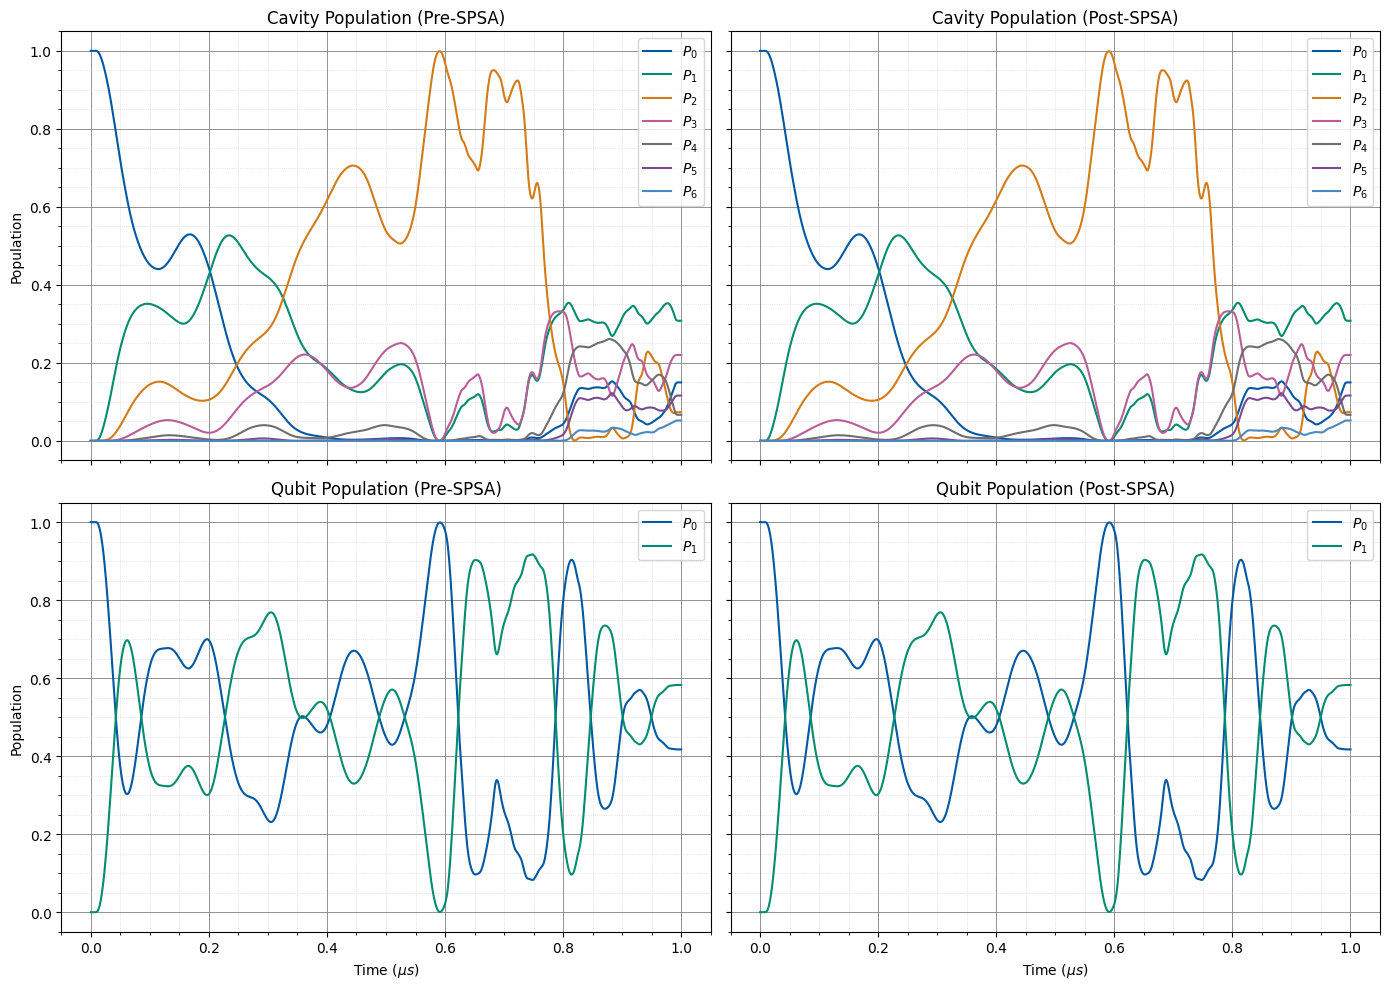

In [ ]:
colors = [
    "#0058A3",
    "#008C6E",
    "#D47A17",
    "#B95D99",
    "#6E6E6E",
    "#7A4A91",
    "#4A89C0",
    # "#C04851",
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey='row')

# --- Top-Left: Cavity Population (Generated Pulse) ---
ax = axes[0, 0]
for j, c in enumerate(colors):
    ax.plot(tsave, prob_sim_gen[j, :], '-', label=f'$P_{j}$', color=c)
ax.set_title('Cavity Population (Pre-SPSA)')
ax.set_ylabel('Population')
ax.legend()

# --- Top-Right: Cavity Population (SPSA Pulse) ---
ax = axes[0, 1]
for j, c in enumerate(colors):
    ax.plot(tsave, prob_sim_spsa[j, :], '-', label=f'$P_{j}$', color=c)
ax.set_title('Cavity Population (Post-SPSA)')
ax.legend()

# --- Bottom-Left: Qubit Population (Generated Pulse) ---
ax = axes[1, 0]
for j in range(ntr):
    ax.plot(tsave, prob_qb_sim_gen[j, :], '-', label=f'$P_{j}$', color=colors[j])
ax.set_title('Qubit Population (Pre-SPSA)')
ax.set_ylabel('Population')
ax.set_xlabel('Time ($\\mu s$)')
ax.legend()

# --- Bottom-Right: Qubit Population (SPSA Pulse) ---
ax = axes[1, 1]
for j in range(ntr):
    ax.plot(tsave, prob_qb_sim_spsa[j, :], '-', label=f'$P_{j}$', color=colors[j])
ax.set_title('Qubit Population (Post-SPSA)')
ax.set_xlabel('Time ($\\mu s$)')
ax.legend()

# Apply grids to all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.grid(True, which='major', linestyle='-', linewidth='0.6', color='gray')
        ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
        ax.minorticks_on() 
        

plt.tight_layout()

In [ ]:
# We should also have a comparison of before and after pulse shapes for SPSA
%matplotlib inline
print("Verifying the pre-trained pulse...")

# Prepare the time vector input for the model
time_array = my_params['tpulse'][:-1]
time_input = tf.constant(time_array, dtype=tf.float64)
time_input = tf.reshape(time_input, (1, len(time_array), 1))


# Numerically compare by calculating the Mean Squared Error
mse = np.mean(np.abs(np.square(generated_pulse_np - ideal_pulse_complex)))
print(f"Mean Squared Error (NN vs Ideal): {mse:.6f}")

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(gen_pulse[0, :]), 'b-', label='Sim (Re)')
axs[0].plot(time_array, np.imag(gen_pulse[0, :]), 'r-', label='Sim (Im)')
axs[0].plot(time_array, np.real(spsa_pulse[0, :]), 'b--', label='SPSA (Re)')
axs[0].plot(time_array, np.imag(spsa_pulse[0, :]), 'r--', label='SPSA (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(gen_pulse[1, :]), 'b-', label='Sim (Re)')
axs[1].plot(time_array, np.imag(gen_pulse[1, :]), 'r-', label='Sim (Im)')
axs[1].plot(time_array, np.real(spsa_pulse[1, :]), 'b--', label='SPSA (Re)')
axs[1].plot(time_array, np.imag(spsa_pulse[1, :]), 'r--', label='SPSA (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

%matplotlib qt

### Wigner & fidelity check:

In [ ]:
# Load the optimizer and SPSA optimized pulse
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer.load_model_weights(directory + 'spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5')
print('\nModel loaded, proceed to SPSA hardware tuning')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/spsa_tuned_cat_alpha=2.2_2025-10-14_18-27-42.weights.h5

Model loaded, proceed to SPSA hardware tuning


In [ ]:
# my_test_params = my_params.copy()

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = (-0.0242 + 0.0 ) * (2 * np.pi)
chi = (-3.649 - 0.01) * (2 * np.pi)
chi_prime = (+0.039 - 0.0) * (2 * np.pi)

# Detuning on qubit and cavity drives
det_osc = 0.015*(2*np.pi)
det_qb = -0.015*(2*np.pi)

T1q = 70
T2q = 30
Tphiq = (1/T2q - 1/(2*T1q))**(-1)

T1c = 200
T2c = 280
Tphic = (1/T2c - 1/(2*T1c))**(-1)

c_ops = [
        jnp.sqrt(1/T1q)*dq.tensor(idcav, t),
        jnp.sqrt(1/Tphiq)*dq.tensor(idcav, tdag @ t),
        jnp.sqrt(1/T1c)*dq.tensor(a, idtr), 
        jnp.sqrt(1/Tphic)*dq.tensor(adag @ a, idtr),
        ]

params = my_test_params.copy()

a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
idcav = dq.eye(params['ncav'])
idtr = dq.eye(params['ntr'])

if params['osc_drive'] == 'linear':
    osc_pow = 1
elif params['osc_drive']=='squeeze':
    osc_pow = 2

# Add noise to the drive
# iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
# amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
# amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

# noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
noisy_amps = optimizer.generate_pulse()

# Add detuning to the drives
qb_det_phi = det_qb * params['tpulse'][:-1]
osc_det_phi = det_osc * params['tpulse'][:-1]
det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

# time-dependent Hamiltonian
# (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
H = my_test_params['H0'] + Hcr + Hci + Htr + Hti

options = dq.Options(progress_meter = None)
solver = dq.method.Tsit5(max_steps = int(1e9))

evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
# evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)

osc_states = dq.ptrace(evo_result.states[0,:], dims = (params['ncav'], params['ntr']), keep = (0,))

Generating pulse from the trained model...


In [ ]:
utl.compute_fidelity_loss(evo_result)
cat_state = (dq.coherent(ncav, 2.2) + dq.coherent(ncav, -2.2)).unit()
cat_state_dm = cat_state @ cat_state.dag()
dq.trace(osc_states[-1] @ cat_state_dm)

Array(0.96019+1.395506e-10j, dtype=complex64)

In [ ]:
dq.plot.wigner(osc_states[-1], xmax = 3.5)
# plt.plot(sampled_coords[:,0], sampled_coords[:,1], 'k*')

In [ ]:
dq.plot.wigner(cat_state, xmax = 3.8)
plt.plot(sampled_coords[:,0], sampled_coords[:,1], 'k*')

### robustness check: 

In [ ]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer2 = HardwareAwareOptimizer(my_test_params, fourier_scale = 12)
optimizer2.load_model_weights(directory + 'SPSA_tuned_model.weights.h5')

optimizer = HardwareAwareOptimizer(my_test_params, fourier_scale = 12)
optimizer.load_model_weights(directory + 'SPSA_tuned_model_non_robust.weights.h5')
print('\nModels loaded')

In [ ]:
def chi_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    
    orig_H0 = params['H0'] + Hcr + Hci + Htr + Hti
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, det in enumerate(dets): 
        H = orig_H0 + det * dq.tensor(a @ adag, t @ tdag)
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [ ]:
# ### Check robustness of the fine-tuned pulse: 
chi_dets = np.linspace(-0.25, 0.25, 11)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = chi_robustness(rob_pulse, chi_dets, my_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = chi_robustness(gen_pulse, chi_dets, my_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [ ]:
plt.figure()
plt.plot(chi_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(chi_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Chi Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

In [ ]:
def qb_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))

    orig_H0 = params['H0'] + Hcr + Hci 
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, qb_det in enumerate(dets):
        
        qb_det_phase = qb_det * params['tpulse'][:-1]
        phasor = jnp.exp(-1j * qb_det_phase) 
        qb_amp = amps[1,:]*phasor

        Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(qb_amp)), dq.tensor(idcav, t+tdag))
        Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(qb_amp)), -1j * dq.tensor(idcav, (t - tdag)))
        
        H = orig_H0 + Htr + Hti
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [ ]:
# ### Check robustness of the fine-tuned pulse: 
qb_dets = np.linspace(-0.95, 0.95, 21)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = qb_robustness(rob_pulse, qb_dets, my_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = qb_robustness(gen_pulse, qb_dets, my_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [ ]:
plt.figure()
plt.plot(qb_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(qb_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Qubit Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')